# Note prediction!

### Simple explorations
1. Handling MIDI files
    * [ ] How to load a MIDI file and play it in python
    * [ ] How to convert a MIDI file to audio
    * [ ] Frequencies to MIDI pitches and vice-versa?
2. Audio files
    * [x] Load a wav file?
    * [x] Sampling rate?
    * [x] What does it even look like???
3. Frequency transforms
    * [x] Audio -> STFT
    * [x] Audio -> constant Q transform
    * [x] Visualize each of those!
    
### Setup evaluation metrics
* [ ] GT data for each time frame
* [ ] "evaluate_one_file" or something: P/R/F1
* [ ] Explore the number of classes and statistics

### Naive classifiers
* [ ] Point window, take frequency with the highest amplitude?
* [ ] Sliding window, run CNN on it to make the prediction
    
### Later?
* [ ] What are the MEL features??


## Next steps
### Compare against real baselines
and see where to go next



## NOTES
- At each time step, you are just capturing a "tone". It's not a frequency, not an amplitude, nothing! It'll be the sum of the values of each component sine wave.
- SR determines how many tones samples (tones) you would capture per second
- Based on the values, you can plot or reconstruct the signal
- Using "some analysis" on the signal, you can try to figure out which base frequencies make up the signal - DFT / FFT (optimized)
- However, the audio keeps changing with time (we keep playing more notes and older ones fade away). So, we need to do a similar frequency analysis on shorter time windows. Use Short-Time-Fourier-Transform for this with a constant window size!
- A constant Q transform is another signal analysis technique. This tries to bin the ...?????

In [1]:
%load_ext autoreload
%autoreload 2

In [77]:
from scipy import signal
import IPython.display as ipydisplay
import librosa
import librosa.display as ldisplay
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import scipy.io.wavfile as wav
%matplotlib inline

### Find the data

In [5]:
path_to_data = pathlib.Path('/home/anuj/data/ftps.tsi.telecom-paristech.fr/share/maps/ENSTDkCl/MUS/')
wav_files = list(path_to_data.glob('**/*.wav'))

### Read one file

In [11]:
wav_file_path = wav_files[0]

data, sr = librosa.load(wav_file_path, sr=None)
data.shape, sr

### Visualize and hear the audio

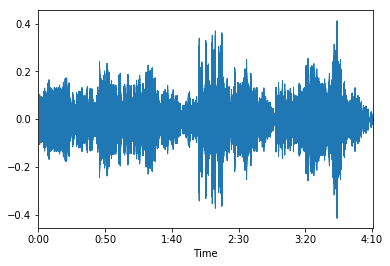

In [33]:
ldisplay.waveplot(data, sr=sr)

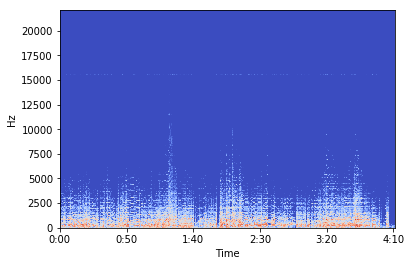

In [63]:
# STFT spectrum
stft = librosa.stft(data)
stft_db = librosa.amplitude_to_db(abs(stft))
ldisplay.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz')

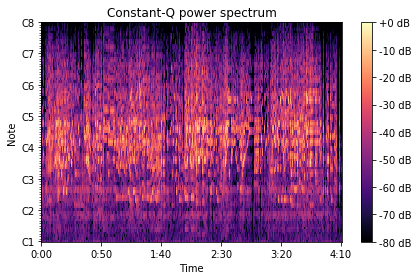

In [62]:
# Constant Q-transform spectrum
C = np.abs(librosa.cqt(data, sr=sr))
librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                         sr=sr, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrum')
plt.tight_layout()

In [51]:
def get_minutes_seconds(data, sr):
    duration = data.shape[0] / sr / 60
    minutes = math.floor(duration)
    seconds = (duration - minutes) * 60
    print(duration, minutes, seconds)
    return duration, minutes, seconds

In [86]:
get_minutes_seconds(data, sr)

4.183883219954648 4 11.032993197278884


(4.183883219954648, 4, 11.032993197278884)

In [87]:
4.2 * 60

252.0

## Load the ground truth data

In [64]:
annot_file_path = wav_file_path.with_suffix('.txt')
df_annot = pd.read_csv(annot_file_path, sep='\t', )
target_onsets = df_annot.OnsetTime.values

target_onsets = np.unique(target_onsets)
target_onsets = np.round(target_onsets, decimals=2)

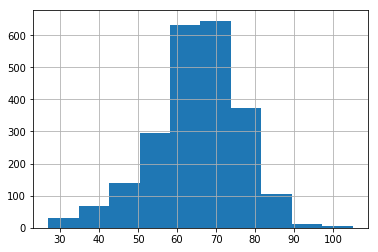

In [94]:
df_annot.MidiPitch.hist()

### Pred onsets

In [100]:
import mir_eval

In [272]:
pred_onsets = librosa.onset.onset_detect(y=data, sr=sr, units='time', backtrack=True)

In [273]:
pred_onsets = np.unique(pred_onsets)
pred_onsets = np.round(pred_onsets, decimals=2)

In [274]:
mir_eval.onset.evaluate(target_onsets, pred_onsets)

OrderedDict([('F-measure', 0.8269230769230769),
             ('Precision', 0.9616613418530351),
             ('Recall', 0.7253012048192771)])

In [278]:
target_onsets

array([  0.52,   0.73,   0.94, ..., 246.64, 246.73, 249.17])

Text(0,0.5,'Accuracy')

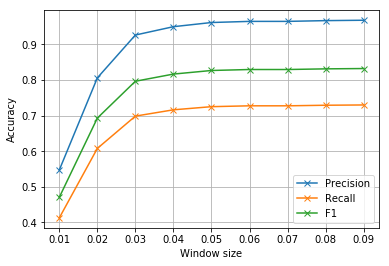

In [275]:
windows = list(np.arange(0.01, 0.1, 0.01))
scores = []
for window in windows:
    scores.append(mir_eval.onset.evaluate(target_onsets, pred_onsets, window=window))

plt.plot(windows, [score['Precision'] for score in scores], 'x-', label='Precision')
plt.plot(windows, [score['Recall'] for score in scores], 'x-', label='Recall')
plt.plot(windows, [score['F-measure'] for score in scores], 'x-', label='F1')

plt.legend()
plt.grid()
plt.xlabel('Window size')
plt.ylabel('Accuracy')

In [276]:
mir_eval.onset.evaluate(target_onsets, pred_onsets, window=100)

OrderedDict([('F-measure', 0.8598901098901098),
             ('Precision', 1.0),
             ('Recall', 0.7542168674698795)])

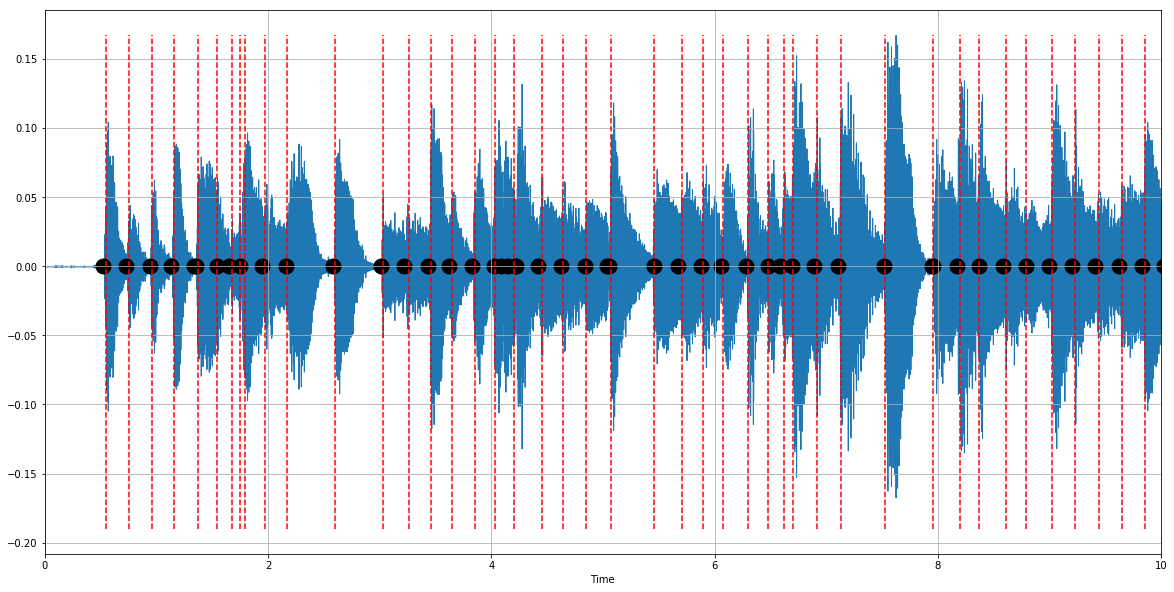

In [164]:
signal_crop = data[:10 * sr]

plt.figure(figsize=(20, 10))
ldisplay.waveplot(signal_crop, sr=sr)

plt.vlines(pred_onsets[:50], min(signal_crop), max(signal_crop), colors='r', linestyles='--')
plt.scatter(target_onsets[:100], [0] * 100, linewidths=10, color='black')
plt.grid()

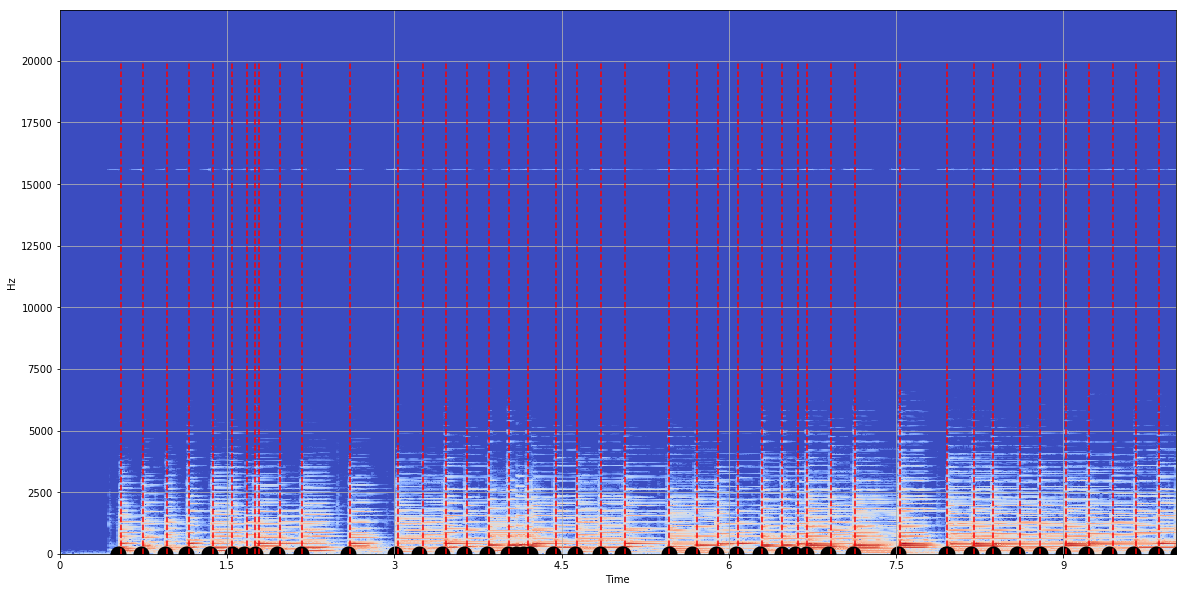

In [170]:
signal_crop = data[:10 * sr]

stft = librosa.stft(signal_crop)
stft_db = librosa.amplitude_to_db(abs(stft))
ldisplay.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz')

plt.figure(figsize=(20, 10))
plt.vlines(pred_onsets[:50],ymin=0, ymax=20000, colors='r', linestyles='--')
plt.scatter(target_onsets[:100], [0] * 100, linewidths=10, color='black')
plt.grid()

## Plot specific windows

In [254]:
def plot_signal_onsets(ax, signal, sr, target_onsets, pred_onsets, start_s, end_s, **kwargs):
    signal_crop = signal[start_s*sr: end_s*sr]

    ldisplay.waveplot(signal_crop, sr=sr, **kwargs)

    preds_to_plot = pred_onsets[np.bitwise_and(start_s <= pred_onsets[:], pred_onsets[:] <= end_s)] - start_s
    targets_to_plot = target_onsets[np.bitwise_and(start_s <= target_onsets[:], target_onsets[:] <= end_s)] - start_s

    ax.vlines(preds_to_plot, min(signal_crop), max(signal_crop), colors='r', linestyles='--')
    ax.scatter(targets_to_plot, [0] * len(targets_to_plot), linewidths=10, color='black')
    ax.grid()

In [258]:
def plot_spec_onsets(ax, signal, sr, target_onsets, pred_onsets, start_s, end_s, **kwargs):
    signal_crop = signal[start_s*sr: end_s*sr]

    stft = librosa.stft(signal_crop)
    stft_db = librosa.amplitude_to_db(abs(stft))
    ldisplay.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz')

    preds_to_plot = pred_onsets[np.bitwise_and(start_s <= pred_onsets[:], pred_onsets[:] <= end_s)] - start_s
    targets_to_plot = target_onsets[np.bitwise_and(start_s <= target_onsets[:], target_onsets[:] <= end_s)] - start_s

    ax.vlines(pred_onsets[:50],ymin=0, ymax=20000, colors='r', linestyles='--')
    ax.scatter(targets_to_plot, [0] * len(targets_to_plot), linewidths=10, color='black')
    ax.grid()

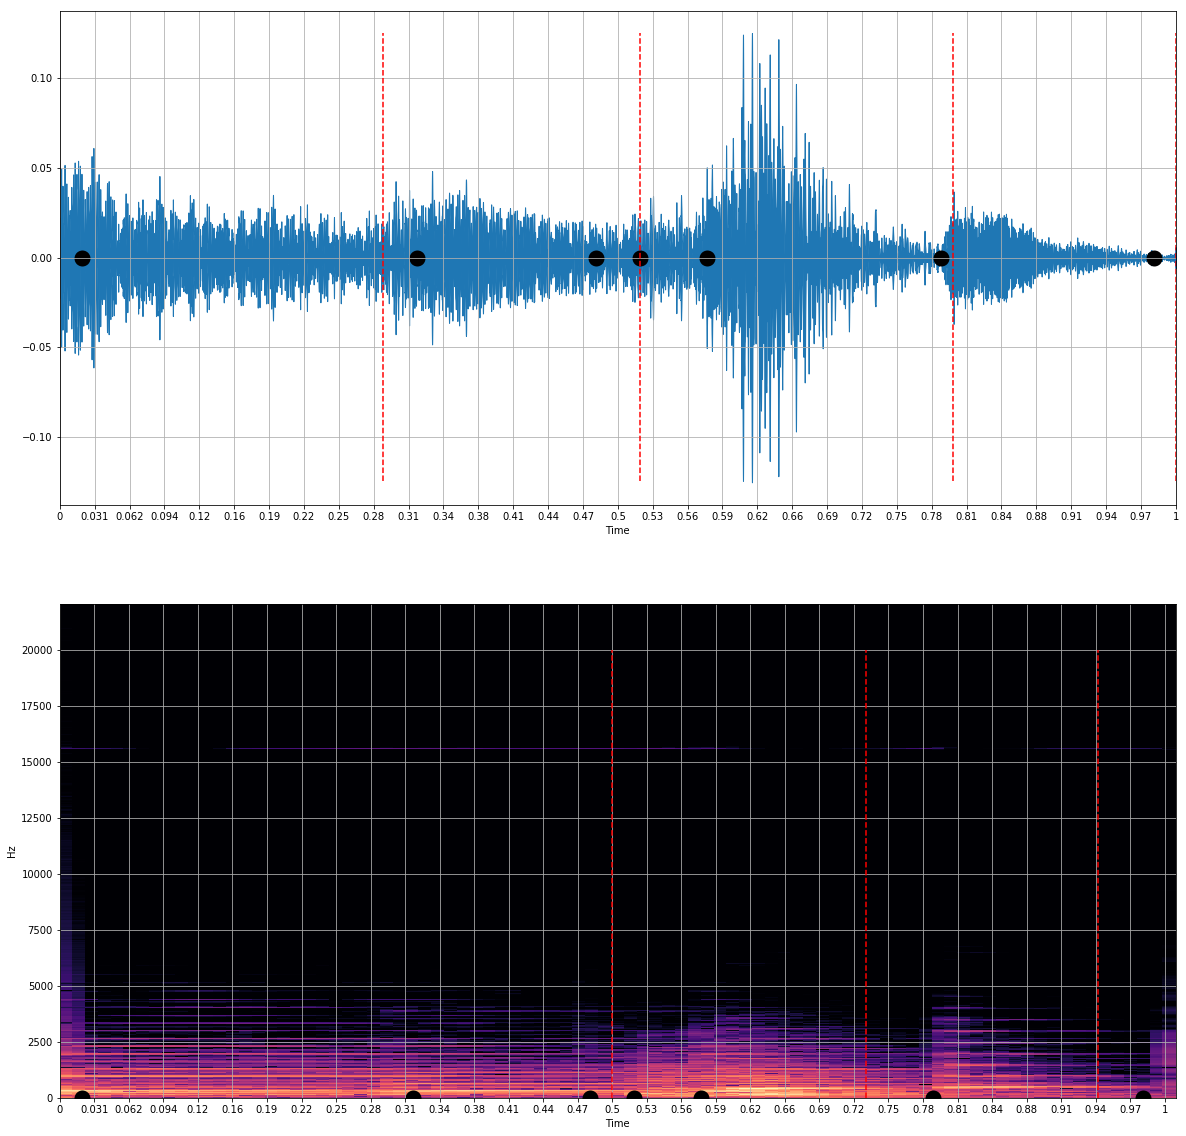

In [282]:
seconds_in_seg = 1
n_segs = 1
OFFSET = 100

plt.figure(figsize=(20, 20*n_segs))
for ix in range(n_segs):
    start_s = (ix * seconds_in_seg) + OFFSET
    end_s = (ix + 1) * seconds_in_seg + OFFSET

    ax = plt.subplot(2 * n_segs, 1, ix*2+1)
    plot_signal_onsets(ax, data, sr, target_onsets, pred_onsets=pred_onsets, start_s=start_s, end_s=end_s)
    plt.xticks(np.linspace(0, 1, 33))

    ax = plt.subplot(2 * n_segs, 1, ix*2+2)
    plot_spec_onsets(ax, data, sr, target_onsets, pred_onsets=pred_onsets, start_s=start_s, end_s=end_s)
    plt.xticks(np.linspace(0, 1, 33))